In [7]:
import kwant 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib widget

from dataclasses import dataclass

mpl.rcParams.update({'font.size': 20, 'text.usetex': False,  'font.family': 'serif', 'font.serif': ['Computer Modern']})


In [8]:
@dataclass
class parameters:
    L: float
    W:float
    t: float
    mu: float
    energy: float
    V: float
    a: float

In [9]:
# Setting up the simplest system ever:
def simplest_system(params):
    syst = kwant.Builder()
    lat = kwant.lattice.square(a = params.a)

    syst[(lat(i , j) for i in range(params.L // params.a) for j in range(params.W // params.a))] = -params.mu + 4*params.t + params.V
    syst[lat.neighbors()] = -params.t

    lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))
    lead[(lat(0 , j) for j in range(params.W // params.a))] = -params.mu + 4*params.t
    lead[lat.neighbors()] = -params.t

    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    return syst.finalized()

In [19]:
from kwant.physics.leads import setup_linsys , selfenergy
from _common import extract_kwant_matrices
params = parameters(L = 10 , W = 10 , t = 1 , mu= 0.5 , energy = 0 , V = 0 , a = 1)
system = simplest_system(params)

# Extracting Kwant Matrices of the scattering region, the leads and the the matrix that connects the leads to the scattering region
H_scattering , H_leads , V_leads , transf = extract_kwant_matrices(system)

# Setting up the generalised eigenvalue problem for each lead:
linearsysL = setup_linsys(H_leads[0] , V_leads[0])
linearsysR = setup_linsys(H_leads[1] , V_leads[1])

eigenproblemL = linearsysL.eigenproblem
eigenproblemR = linearsysR.eigenproblem

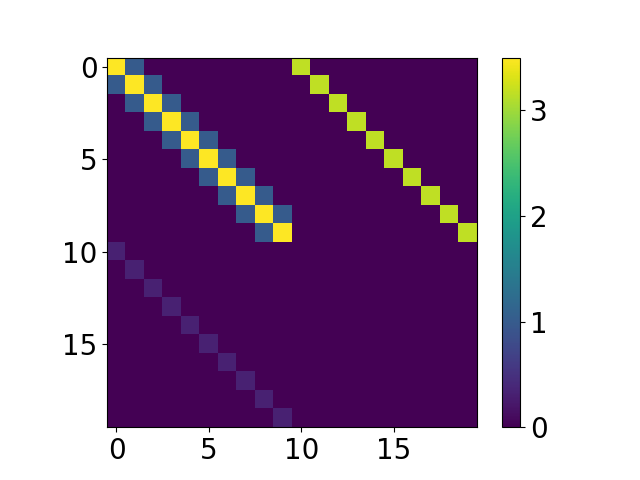

In [20]:
plt.figure()
plt.imshow(np.abs(eigenproblemL[0]))
plt.colorbar()

In [22]:
# We can also calculate the self energies of each lead;
self_energy_L = selfenergy(H_leads[0], V_leads[0])
self_energy_R = selfenergy(H_leads[1], V_leads[1])

In [26]:
print(self_energy_R.shape)

(10, 10)


In [81]:
fromsite = np.linspace(0 , params.L*9 , 10, dtype = int)
print(fromsite)

[ 0 10 20 30 40 50 60 70 80 90]


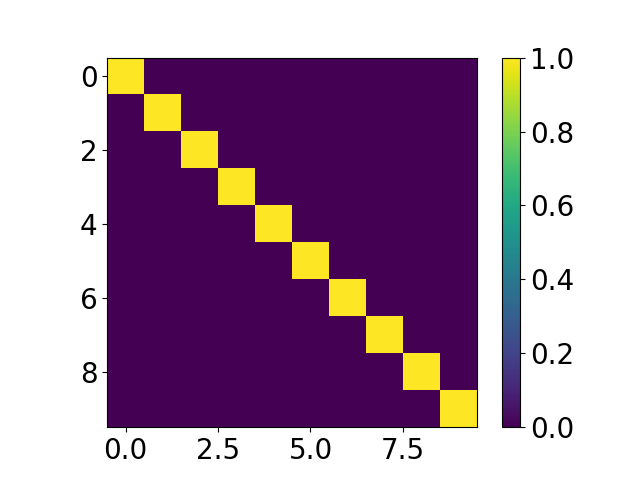

In [96]:
# system.sites[0].family
# system.sites[0]

def subham(syst , j1 , j2):
        fromsite = np.linspace(0 , params.W*(params.L - 1) , 10 , dtype = int) + j1
        tosite = fromsite + (j2 - j1)
        return syst.hamiltonian_submatrix(from_sites = fromsite.tolist() , to_sites = tosite.tolist())

plt.figure()
plt.imshow(np.abs(subham(system , 0 , 1)))
plt.colorbar()




TypeError: object of type 'function' has no len()

In [98]:
# Calculating the initial matrices for the recursive Green's function algorithm using self energies:
G_00 = np.linalg.inv(params.energy - H_leads[0] - self_energy_L)
G_end_end = np.linalg.inv(params.energy - H_leads[1] - self_energy_R)

# Using recursive procedure to calculate Left Green's functions:
G_left_nn = np.zeros(shape = (G_00.shape[0] , G_00.shape[1] , params.L) , dtype = np.complex128)
G_left_n_0 = np.zeros(shape = (G_00.shape[0] , G_00.shape[1] , params.L) , dtype = np.complex128)
G_left_nn[: , : , 0] = G_00
G_left_n_0[: , : , 0] = G_00

from tqdm import tqdm

for i in tqdm(range(params.L)):
    if i > 0:
        G_left_nn[: , : , i] = np.linalg.inv(params.energy*np.identity(G_00.shape[0]) - subham(system , i , i) - subham(system,i , i-1)@G_left_nn[: , :, i-1]@subham(system,i-1 , i))
        G_left_n_0[: , : , i] = G_left_nn[: , : , i]@subham(system , i , i-1)@G_left_n_0[: , : , -1]



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 188.28it/s]
